<a href="https://colab.research.google.com/github/PranavPhanindra/Deep-Learning-PyTorch/blob/main/23357_MTCS_205P_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Data Loading and info about Data

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

#Defining labels for different classes of dataset

(-0.5, 27.5, 27.5, -0.5)

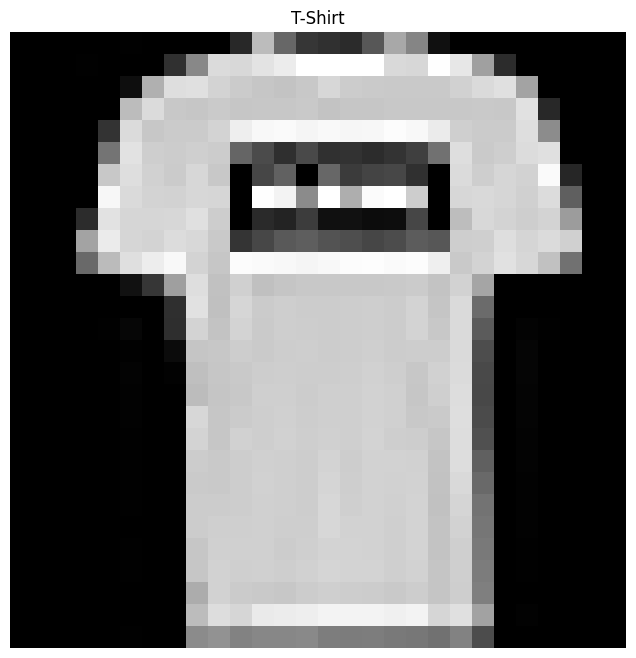

In [4]:
figure = plt.figure(figsize=(8, 8))
img,label = training_data[1]
img = img.reshape(28,28)
plt.imshow(img,cmap='gray')
plt.title(labels_map[label])
plt.axis("off")

In [5]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

# Creating Neural Network Class

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            #Layer 1 - 64 Nodes
            #Layer 2 - 128 Nodes
            #Relu Activation for each layer
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64 , 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Checking for the devices we have so that we can run the code either on GPU or on CPU

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [8]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


Hyper Parameters

In [9]:
learningRate = 1e-3
batchSize  = 64
epochs = 5

In [10]:
#Combines LogSoftmax and NLLLoss - Negativce log likelihood
lossFn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model.parameters(),lr = learningRate)
optimizer2  = torch.optim.Adam